In [6]:
import numpy as np
import cnfgen
from pysat.formula import CNF
from pysat.solvers import Glucose3
import pickle
import random
import glob
from os.path import join
import moser_rust
from generate_random_instances import create_candidates_with_sol
import time


4.82


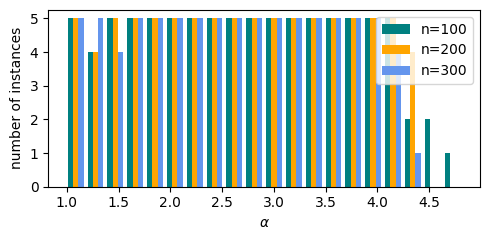

In [26]:
import glob
from pysat.formula import CNF
import matplotlib.pyplot as plt
path = "/Users/p403830/Downloads/samples_random_3SAT/"
alpha_values_300 = []
alpha_values_200 = []
alpha_values_100 = []
n_values = []
instances = glob.glob(path + "*.cnf")
n_100 = []
n_200 = []
n_300 = []
for g in instances:
    cnf_formula = CNF(from_file=g)
    n = cnf_formula.nv
    m = len(cnf_formula.clauses)
    if n==300:
        alpha_values_300.append(m/n)
        n_300.append(n)
    if n==200:
        alpha_values_200.append(m/n)
        n_200.append(n)
    if n==100:
        alpha_values_100.append(m/n)
        n_100.append(n)
plt.figure(figsize=(5,2.5))
plt.hist([alpha_values_100,alpha_values_200,alpha_values_300], label = ["n=100","n=200","n=300"], color = ["teal", "orange", "cornflowerblue"], bins = 20, histtype='bar')
print(max(alpha_values_100))
plt.xlabel(r"$\alpha$")
plt.ylabel("number of instances")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/p403830/Downloads/samples_random_3SAT/train_dataset_random-3-SAT.png", dpi = 300, format = "png")
plt.show()

2052
4.5
4.45
4.5


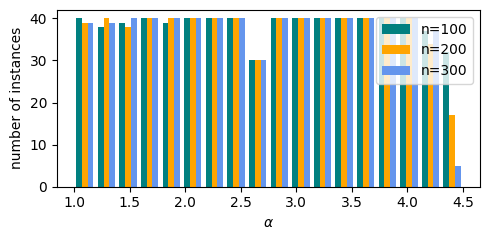

In [33]:
import glob
from pysat.formula import CNF
import matplotlib.pyplot as plt
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_evaluation_vary_zero/"
alpha_values_300 = []
alpha_values_200 = []
alpha_values_100 = []
n_values = []
instances = glob.glob(path + "*.cnf")
n_100 = []
n_200 = []
n_300 = []
print(len(instances))
for g in instances:
    
    cnf_formula = CNF(from_file=g)
    n = cnf_formula.nv
    m = len(cnf_formula.clauses)
    if n==300:
        alpha_values_300.append(m/n)
        n_300.append(n)
    if n==200:
        alpha_values_200.append(m/n)
        n_200.append(n)
    if n==100:
        alpha_values_100.append(m/n)
        n_100.append(n)
plt.figure(figsize=(5,2.5))
print(max(alpha_values_200))
print(max(alpha_values_300))
plt.hist([alpha_values_100,alpha_values_200,alpha_values_300], label = ["n=100","n=200","n=300"], color = ["teal", "orange", "cornflowerblue"], bins = 18, histtype='bar')
print(max(alpha_values_100))
plt.xlabel(r"$\alpha$")
plt.ylabel("number of instances")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/p403830/Downloads/samples_random_3SAT/eval_new_dataset_random-3-SAT.png", dpi = 300, format = "png")
plt.show()

584
3.9


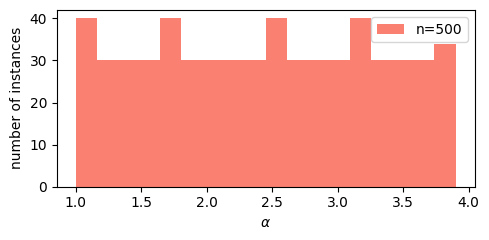

In [35]:
import glob
from pysat.formula import CNF
import matplotlib.pyplot as plt
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT_n500_evaluation_vary_zero/"
alpha_values = []

n_values = []
instances = glob.glob(path + "*.cnf")
print(len(instances))
for g in instances:
    cnf_formula = CNF(from_file=g)
    n = cnf_formula.nv
    m = len(cnf_formula.clauses)
    alpha_values.append(m/n)
plt.figure(figsize=(5,2.5))
plt.hist([alpha_values], label = ["n=500"], color = ["salmon"], bins = 18, histtype='bar')
print(max(alpha_values))
plt.xlabel(r"$\alpha$")
plt.ylabel("number of instances")
plt.legend()
plt.tight_layout()
plt.savefig("/Users/p403830/Downloads/samples_random_3SAT/eval_n500_dataset_random-3-SAT.png", dpi = 300, format = "png")
plt.show()

In [3]:
# definition of some functions that might come in handy...

def find_prob_matrix(matrix, p):
    p_double = np.array([p,1-p]).transpose()
    positive = abs(matrix * np.array([p_double[:,0]]).transpose() - abs(matrix) * np.array([p_double[:,0]]).transpose())/2
    negative = abs(matrix * np.array([p_double[:,1]]).transpose() + abs(matrix) * np.array([p_double[:,1]]).transpose())/2
    mask = np.where(np.sum(abs(matrix), axis = 0)!=0, 1, 0)*np.ones(matrix.shape)
    zeros = (np.ones(np.shape(matrix)) - abs(matrix)) * mask
    return negative + positive + zeros

def find_induced_probs(matrix, p):
    return np.prod(find_prob_matrix(matrix, p), axis = 0)

def find_neighbors(matrix, conflicting_only = False):
    occurencies_matrix =abs(matrix)
    neighbors_indices_list = []
    neighbors_number_list = []
    for i in range(np.shape(occurencies_matrix)[1]):
        target = matrix[:,i][:, None]

        if conflicting_only == False:
            a = np.where(np.sum(occurencies_matrix[:,0:i] * abs(target), axis = 0)!=0, 1, 0)
            b = np.where(np.sum(occurencies_matrix[:,i+1:np.shape(occurencies_matrix)[1]] * abs(target), axis = 0)!=0, 1, 0)
        if conflicting_only == True:
            a = np.where(np.sum(((occurencies_matrix[:,0:i] * abs(target)) - (matrix[:, 0:i] * target))/2, axis = 0) != 0 , 1, 0)
            b = np.where(np.sum(((occurencies_matrix[:,i+1:np.shape(occurencies_matrix)[1]] * abs(target)) - (matrix[:, i+1:np.shape(occurencies_matrix)[1]] * target))/2, axis = 0) != 0, 1, 0)
        
        a = np.hstack((a,[0]))      
        remainder = np.hstack((a, b))
        neighbors_number = np.sum(remainder)
        neighbors_indices = np.argwhere(remainder != 0).transpose()[0]
        neighbors_number_list.append(neighbors_number)
        neighbors_indices_list.append(neighbors_indices)

    return(neighbors_indices_list,neighbors_number_list)

def get_rhs(matrix, x, conflicting_only = False):
    neighbors_indices_list,neighbors_number_list = find_neighbors(matrix, conflicting_only=conflicting_only)
    m = len(neighbors_indices_list)
    rhs_array = np.zeros(m)
    for current_clause in range(m):
        rhs = x[current_clause]
        for neighbor in neighbors_indices_list[current_clause]:
            rhs = rhs * (1-x[neighbor])
        rhs_array[current_clause] = rhs
    return rhs_array

def check_uniqueness_condition(matrix):
    unique_matrix = np.unique(matrix, axis = 1)
    return ((matrix.shape[1] - np.sum(np.where(np.sum(matrix, axis= 0)!= 0, 0, 1))) - (unique_matrix.shape[1] - np.sum(np.where(np.sum(unique_matrix, axis= 0)!= 0, 0, 1))) == 0)

# define a translation from matrix to CNF

def translate_matrix_to_CNF(matrix):
    cnf = CNF()
    for i in range(matrix.shape[1]):
        variables = np.arange(1, matrix.shape[0]+1)
        a = variables * matrix[:, i]
        a = np.int_(a[a!=0])
        cnf.append(a)
    return cnf

def save_cnf(matrix, p, x, path):
    cnf = translate_matrix_to_CNF(matrix)
    cnf.to_file(path + ".cnf")
    generators = np.array([p, x, matrix], dtype = object)
    np.save(path + "_generators.npy", generators)

# determine the solution 

def get_solution(path, N_STEPS_MOSER, N_RUNS_MOSER, SEED):
    problem_path = path + ".cnf" 
    model_probabilities, _, _= np.load(path + "_generators.npy", allow_pickle=True)

    status, sol, final_energies = moser_rust.run_moser_python(
                    problem_path,
                    model_probabilities,
                    N_STEPS_MOSER,
                    N_RUNS_MOSER,
                    SEED,
            )
    return status, sol


def create_candidates_with_sol(data_dir, sample_size, threshold):
    solved_instances = glob.glob(join(data_dir, "*_sol.pkl"))
    for g in solved_instances:
        with open(g, "rb") as f:
            p = pickle.load(f)
        n = np.array(list(p), dtype=bool)
        samples = sample_candidates(n, sample_size - 1, threshold)
        samples = np.concatenate((np.reshape(n, (1, len(n))), samples), axis=0)
        name = g.split("_sol.pkl")[0]
        with open(name + "_samples_sol.npy", "wb") as f:
            np.save(f, samples)


def sample_candidates(original, sample_size, threshold):
    np.random.seed(sum(original))
    condition = np.random.random((sample_size, original.shape[0])) < threshold
    return np.where(condition, np.invert(original), original)


def get_solutions_in_folder(data_dir, N_STEPS_MOSER = 100, N_RUNS_MOSER= 5, SEED = 0):
    sampled_instances = glob.glob(join(data_dir, "*.cnf"))
    for g in sampled_instances:
        model_probabilities, _, _ = np.load(g.split(".cnf")[0] + "_generators.npy", allow_pickle=True)
        status, sol, final_energies = moser_rust.run_moser_python(
                    g,
                    model_probabilities,
                    N_STEPS_MOSER,
                    N_RUNS_MOSER,
                    SEED,
            )
        if status:
            with open(g.split(".cnf")[0] + "_sol.pkl", "wb") as f:
                pickle.dump(sol, f)
        else:
            print("unsol")
            with open(g.split(".cnf")[0] + "_unsol.pkl", "wb") as f:
                pickle.dump(sol, f)


In [6]:
# do an optimization of x assignment

from scipy.optimize import minimize


def check_LLL_condition(matrix, p, x, conflicting_only = False):
    induced_probs = find_induced_probs(matrix, p)
    rhs = get_rhs(matrix, x, conflicting_only=conflicting_only)
    # print(induced_probs - rhs)
    # print(np.less_equal(induced_probs - rhs, 0))
    # print(np.all(np.less_equal(induced_probs - rhs, 0)))
    return np.all(np.less_equal(induced_probs - rhs, 0))


def satisfies_lll_masked(matrix, p, conflicting_only = False):
    d_list = find_neighbors(matrix, conflicting_only = conflicting_only)[1]
    x_list = 1/(d_list + np.ones(len(d_list)))
    rhs = get_rhs(matrix, x_list, conflicting_only=conflicting_only)
    induced_probs = find_induced_probs(matrix, p)
    return np.all(np.less_equal(induced_probs - rhs, 0))


def satisfies_lll_optimization_masked(matrix, p, x_list, conflicting_only = False, maxiter = 10):
    def compute_lll_condition(x_list):
        neighbors_indices_list,neighbors_number_list = find_neighbors(matrix, conflicting_only=conflicting_only)
        m = len(neighbors_indices_list)
        rhs_array = np.zeros(m)
        for current_clause in range(m):
            rhs = x_list[current_clause]
            for neighbor in neighbors_indices_list[current_clause]:
                rhs = rhs * (1-x_list[neighbor])
            rhs_array[current_clause] = rhs
        induced_probs = find_induced_probs(matrix, p)
        objective = np.sum(np.maximum(induced_probs - rhs_array,np.zeros(len(induced_probs))))
        #objective = induced_probs - rhs_array
        # objective)
        #print(np.sum(np.maximum(objective, np.zeros(len(objective)))))
        return objective

    lll_condition = check_LLL_condition(matrix, p, x_list, conflicting_only = False)
    if lll_condition == False:
        bounds = (((0,1),)*len(x_list))
        x_optimized = minimize(compute_lll_condition, x_list, method='L-BFGS-B', options={'maxiter': maxiter}, bounds = bounds)
        lll_condition = check_LLL_condition(matrix, p, x_optimized.x, conflicting_only=conflicting_only)
        # print(lll_condition, "optimization")
        if lll_condition :
            # print("optimized works")
            x_list = x_optimized.x
    return lll_condition, x_list


def satisfies_lll_optimization_masked_subset(matrix, p, x_list, index_set, conflicting_only = False, maxiter = 10):
    def compute_lll_condition(x_list_new):
        #print("len x_list", len(x_list))
        for i in range(len(index_set)):
            x_list[index_set[i]] = x_list_new[i]
        #print("len x_list_new", len(x_list_new))
        neighbors_indices_list,neighbors_number_list = find_neighbors(matrix, conflicting_only=conflicting_only)
        
        m = len(neighbors_indices_list)
        rhs_array = np.zeros(m)
        for current_clause in range(m):
            # print("current clause", current_clause)
            rhs = x_list[current_clause]
            for neighbor in neighbors_indices_list[current_clause]:
                rhs = rhs * (1-x_list[neighbor])
            rhs_array[current_clause] = rhs
        induced_probs = find_induced_probs(matrix, p)
        objective = np.sum(np.maximum(induced_probs - rhs_array,np.zeros(len(induced_probs))))
        #objective = induced_probs - rhs_array
        #print(objective)
        #print(np.sum(np.maximum(objective, np.zeros(len(objective)))))
        return objective

    lll_condition = check_LLL_condition(matrix, p, x_list, conflicting_only = False)
    if lll_condition == False:
        x_list_new = x_list[index_set]
        #print("x_list_new", x_list_new)
        bounds = (((0,1),)*len(x_list_new))
        x_optimized = minimize(compute_lll_condition, x_list_new, method='L-BFGS-B', options={'maxiter': maxiter}, bounds = bounds)
        x_list_new_optimized = x_optimized.x
        x_list_new = x_list
        for i in range(len(index_set)):
            x_list_new[index_set[i]] = x_list_new_optimized[i]
        lll_condition = check_LLL_condition(matrix, p,x_list_new, conflicting_only=conflicting_only)
        #print(lll_condition, "optimization")

        if lll_condition:
            # print("optimized works")
            #print("x_list_new_optimized", x_list_new_optimized)
            x_list = x_list_new
    return lll_condition, x_list


def check_LLL_condition(matrix, p, x, conflicting_only = False):
    induced_probs = find_induced_probs(matrix, p)
    rhs = get_rhs(matrix, x, conflicting_only=conflicting_only)
    # print(induced_probs - rhs)
    # print(np.less_equal(induced_probs - rhs, 0))
    # print(np.all(np.less_equal(induced_probs - rhs, 0)))
    return np.all(np.less_equal(induced_probs - rhs, 0))


def generate_new_clause(p, k):
    variables = sorted(np.arange(0,len(p),1))
    chosen_indices = random.sample(variables, k)
    new_clause = np.zeros(len(p))
    for index in chosen_indices:
        prob_pick = p[index]
        new_clause[index] = np.random.choice([int(-1),int(1)], p = [1- prob_pick, prob_pick])
    return new_clause


def update_matrix_clauses_optimized(matrix, p, TIMEOUT_internal, conflicting_only = False, k = False, number_of_clauses_in_one_try = 5):
    t_internal = 0
    x_list = np.zeros(matrix.shape[1])
    added_clauses = 0
    add_here = 0
    while added_clauses < matrix.shape[1] and t_internal <= TIMEOUT_internal:
        if number_of_clauses_in_one_try + added_clauses <= matrix.shape[1]:
            add_here = number_of_clauses_in_one_try
        else:
            add_here = matrix.shape[1] - added_clauses
        status_internal = False
        while status_internal==False and t_internal <= TIMEOUT_internal:
            start_time_total_adding = time.time()
            assert check_LLL_condition(matrix, p, x_list, conflicting_only = conflicting_only) == True
            for _ in range(add_here):
                if _ == 0:
                    #print("copy", _)
                    old_matrix = np.copy(matrix)
                if k == False:
                    k_used = np.random.randint(2, len(p)+1)
                else:
                    k_used = k
                status_uniqueness = False
                while status_uniqueness == False:
                    new_clause = generate_new_clause(p, k_used)
                    matrix[:,added_clauses + _] = new_clause
                    status_uniqueness = check_uniqueness_condition(matrix)
                
                d = find_neighbors(matrix, conflicting_only = False)[1]
                x_list[added_clauses + _] =  1/(1+d[added_clauses + _])

                # maybe also change the other affected terms...
                # print("usual masked", satisfies_lll_masked(matrix, p, conflicting_only = conflicting_only))
                # print("old", x_list)
                
                if _ == add_here - 1:
                    start_time = time.time()
                    # check_LLL, x_list = satisfies_lll_optimization_masked(matrix, p, x_list, conflicting_only = conflicting_only)
                    index_set = np.arange(added_clauses, added_clauses + add_here, 1)
                    #print(index_set)
                    check_LLL, x_list = satisfies_lll_optimization_masked_subset(matrix, p, x_list, index_set, conflicting_only = False, maxiter = 10)
                    print("check", check_LLL)
                    if not check_LLL:
                        #print("check_neighbors")
                        neighbors_list = find_neighbors(matrix, conflicting_only = False)[0]
                        neighbors_affected = list(index_set)
                        for i in index_set:
                            neighbors_affected.extend(list(neighbors_list[i]))
                            neighbors_affected = list(dict.fromkeys(neighbors_affected))
                            neighbors_affected.sort()
                        #print("neighbors", neighbors_affected)
                        check_LLL, x_list = satisfies_lll_optimization_masked_subset(matrix, p, x_list, index_set, conflicting_only = False, maxiter = 10)
                        print("check with neighbors optimization", check_LLL)
                    # print(check_LLL, check_LLL_condition(matrix, p, x_list, conflicting_only = conflicting_only))
                    #print("check_LLL", check_LLL)
                    # print("optimized", x_list)
                    #check_uniqueness = check_uniqueness_condition(matrix)
                    #print("uniqueness", check_uniqueness)
                    #print([check_LLL, check_uniqueness])
                    print("--- optimization took %s seconds ---" % (time.time() - start_time))
                    print("--- whole try took %s seconds ---" % (time.time() - start_time_total_adding))
                    if not np.all([check_LLL]):
                        matrix = old_matrix
                        # print("use old matrix")
                        t_internal += 1
                        if t_internal%5 ==0:
                            print("t=", t_internal)
                        number_of_clauses_in_one_try = int(np.ceil(add_here * 0.5))
                        add_here = number_of_clauses_in_one_try
                        #print("add_here is now:", add_here)
                        
                    else: 
                        status_internal = True
                        added_clauses +=  add_here
                        print("added so far", added_clauses)
    return matrix, x_list


def get_matrix_optimized(p, n, m, k= False, conflicting_only = False, TIMEOUT_internal = 100, TIMEOUT = 1, number_of_clauses_in_one_try = 5):
    matrix = np.zeros((n,m))
    best_matrix = np.zeros(n)[:, None]
    best_matrix_x = 0
    t = 0
    status = False
    # while t < TIMEOUT:
        # matrix, t = update_matrix_single_elements(matrix, p, t, TIMEOUT)
    status_shape = False
    while status_shape == False and t < TIMEOUT :
        matrix, x_list = update_matrix_clauses_optimized(matrix, p, TIMEOUT_internal = TIMEOUT_internal, conflicting_only=conflicting_only, k = k, number_of_clauses_in_one_try = number_of_clauses_in_one_try)
        # matrix = np.unique(matrix, axis = 1)
        # print(matrix)
        cleaned_matrix = []
        cleaned_x = []
        for i in range(matrix.shape[1]):
            if np.sum(abs(matrix[:,i])) > 1:
                cleaned_matrix.append(matrix[:,i])
                cleaned_x.append(x_list[i])
        cleaned_matrix = np.array(cleaned_matrix).T
        if cleaned_matrix.shape[1] == m:
            status_shape = True
            best_matrix = cleaned_matrix
            best_matrix_x = cleaned_x
        else:
            if cleaned_matrix.shape[1] > best_matrix.shape[1]:
                best_matrix = cleaned_matrix
                best_matrix_x = cleaned_x
            matrix = np.zeros((n,m))
            t += 1
        #best_matrix = cleaned_matrix
        #best_matrix_x = cleaned_x
    #d_list = find_neighbors(matrix, conflicting_only = conflicting_only)[1]
    #x_list = 1/(d_list + np.ones(len(d_list)))
    #print("neighbors", np.min(d_list), np.max(d_list))
    #print("x_list", np.min(best_matrix_x), np.max(best_matrix_x))
    #print("optimized", check_LLL_condition(best_matrix, p, best_matrix_x, conflicting_only = conflicting_only))
    #print("masked", satisfies_lll_masked(best_matrix, p, conflicting_only=conflicting_only))
    assert check_LLL_condition(best_matrix, p, best_matrix_x, conflicting_only = conflicting_only) == True
    return best_matrix, best_matrix_x



In [105]:
def sample_LLL_matrix(n, m, k, NUMBER_OF_SAMPLES, path, N_STEPS_MOSER= 1000, N_RUNS_MOSER = 5, SEED = 0, number_of_clauses_in_one_try = 5, lower_value = 0, upper_value =1):
    for _ in range(NUMBER_OF_SAMPLES):
        print("sample: " + str(_) + " of " + str(NUMBER_OF_SAMPLES))
        # generate problem
        p = np.random.rand(n)*(upper_value - lower_value) + lower_value # this is the probability to sample a 1
        matrix, x = get_matrix_optimized(p, n, m, k, conflicting_only = False, number_of_clauses_in_one_try = number_of_clauses_in_one_try)                
        # save problem
        index = str(random.randint(0, 10000000))
        problem_path = path + "n" + str(n) + "k" + str(k) + "m" + str(matrix.shape[1]) + "__" + str(index)
        
        print("matrix, p, x shape", matrix.shape, np.array(p).shape, np.array(x).shape)
        save_cnf(matrix, p, x, problem_path)
        # determine solution and save it
        status, sol = get_solution(problem_path, N_STEPS_MOSER, N_RUNS_MOSER, SEED)
        if status:
            with open(problem_path + "_sol.pkl", "wb") as f:
                pickle.dump(sol, f)
        else:
            with open(problem_path + "_unsol.pkl", "wb") as f:
                pickle.dump(sol, f)

        


"""
n = 10 # np.random.randint(0,1000)
print("n",n)
# p = np.ones(n)/2
p = np.random.rand(n) # this is the probability to sample a 1
print("p", p)
m = 100 # np.random.randint(0,2000)
print("m", m)
k = 5

# matrix = get_matrix_optimized(p, n, m, k= 5, conflicting_only = False)
matrix, x = get_matrix_optimized(p, n, m, k, conflicting_only = False)
print(matrix)
print(np.shape(matrix))
print(np.sum(abs(matrix), axis = 0))
# above was Paul's suggestion

path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_n8/second_example"
save_cnf(matrix, p, x, path)"""

'\nn = 10 # np.random.randint(0,1000)\nprint("n",n)\n# p = np.ones(n)/2\np = np.random.rand(n) # this is the probability to sample a 1\nprint("p", p)\nm = 100 # np.random.randint(0,2000)\nprint("m", m)\nk = 5\n\n# matrix = get_matrix_optimized(p, n, m, k= 5, conflicting_only = False)\nmatrix, x = get_matrix_optimized(p, n, m, k, conflicting_only = False)\nprint(matrix)\nprint(np.shape(matrix))\nprint(np.sum(abs(matrix), axis = 0))\n# above was Paul\'s suggestion\n\npath = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_n8/second_example"\nsave_cnf(matrix, p, x, path)'

In [106]:
n = 100
m = 150
k = 7
lower_value = 0.1
upper_value = 0.9

NUMBER_OF_SAMPLES = 10
N_STEPS_MOSER = 100
N_RUNS_MOSER = 5

number_of_samples_in_one_try = 10

#sample_size = 50
#threshold = 0.03

path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_k7_new/"

sample_LLL_matrix(n, m, k, NUMBER_OF_SAMPLES, path, N_STEPS_MOSER= 1000, N_RUNS_MOSER = 5, SEED = 0, number_of_clauses_in_one_try = number_of_samples_in_one_try, lower_value=lower_value, upper_value = upper_value)
#create_candidates_with_sol(path, sample_size, threshold)

sample: 0 of 10
check True
--- optimization took 0.4857499599456787 seconds ---
--- whole try took 0.7562391757965088 seconds ---
added so far 10
check True
--- optimization took 0.037197113037109375 seconds ---
--- whole try took 0.41021275520324707 seconds ---
added so far 20
check True
--- optimization took 0.9741370677947998 seconds ---
--- whole try took 1.2389230728149414 seconds ---
added so far 30
check False
check with neighbors optimization False
--- optimization took 12.466315031051636 seconds ---
--- whole try took 12.688952922821045 seconds ---
check False
check with neighbors optimization False
--- optimization took 8.140652894973755 seconds ---
--- whole try took 8.262988090515137 seconds ---
check True
--- optimization took 0.33438992500305176 seconds ---
--- whole try took 0.4144871234893799 seconds ---
added so far 33
check False
check with neighbors optimization False
--- optimization took 5.698976039886475 seconds ---
--- whole try took 5.77729606628418 seconds ---


KeyboardInterrupt: 

In [98]:
def combine_two_problems(generators1, generators2, n_list=[], m_list=[]):
    assert len(n_list)==len(m_list)
    p1, x1, matrix1 = generators1
    p2, x2, matrix2 = generators2

    p_new = np.hstack([p1,p2])
    x_new = np.hstack([x1,x2])
    matrix_new = np.block([
                [matrix1, np.zeros((np.shape(matrix1)[0], np.shape(matrix2)[1]))],
                [np.zeros((np.shape(matrix2)[0], np.shape(matrix1)[1])),matrix2]
                ])
    
    if len(n_list) == 0:
        n_list.extend([len(p1),len(p2)])
        m_list.extend([len(x1),len(x2)])
    else:
        n_list.extend([len(p2)])
        m_list.extend([len(x2)])

    return (p_new, x_new, matrix_new), (n_list, m_list)

def combine_multiple_problems(generators_list, n_list=[], m_list=[]):
    new_generators = generators_list[0]
    for i in range(1, len(generators_list)):
        new_generators, (n_list, m_list) = combine_two_problems(new_generators, generators_list[i], n_list, m_list)
    return new_generators, (n_list, m_list)


def sample_new_clause_non_community(p, k, n_m_lists, number_of_sets = 2):
    n_list, _ = n_m_lists
    assert number_of_sets <= len(n_list)
    all_variables_in_sets = []
    counter = 0
    for n in n_list:
        all_variables_in_sets.append(list(np.arange(counter, counter + n)))
        counter += n
    status = False
    chosen_set_indices = sorted(random.sample(range(0,len(n_list)), number_of_sets))
    while status == False:
        set_choices = random.choices(chosen_set_indices, k=k)
        occurencies = [np.count_nonzero([sc==x for sc in set_choices]) for x in range(0,len(n_list))]
        if len(list(dict.fromkeys(set_choices))) == number_of_sets and np.all([np.array(n_list) - np.array(occurencies)>= 0]):
            status = True
    chosen_indices = []
    for i in range(len(n_list)):
        if occurencies[i]!= 0:
            chosen_indices.extend(random.sample(all_variables_in_sets[i], occurencies[i]))
    #print("chosen indices", chosen_indices)
    new_clause = np.zeros(len(p))
    for index in chosen_indices:
        prob_pick = p[index]
        new_clause[index] = np.random.choice([int(-1),int(1)], p = [1- prob_pick, prob_pick])
    return new_clause
  

def add_new_clauses_non_community(new_generators, n_m_lists, k, number_of_clauses_to_add, number_of_sets = 2, conflicting_only = False, TIMEOUT_internal = 1000):
    p, x_list, matrix = new_generators
    t_internal = 0
    added_clauses = 0
    for clause_i in range(number_of_clauses_to_add):
        if clause_i % 5 == 0:
            print("clause", clause_i, "t_internal", t_internal)
        status_internal = False
        while status_internal==False and t_internal <= TIMEOUT_internal:
            old_matrix = np.copy(matrix)
            if k == False:
                k_used = np.random.randint(2, len(p)+1)
            else:
                k_used = k
            new_clause = sample_new_clause_non_community(p, k_used, n_m_lists, number_of_sets = number_of_sets)
            matrix = np.hstack([matrix, np.array([new_clause]).T])
            d = find_neighbors(matrix, conflicting_only = False)[1]
            x_list = np.hstack([x_list,[1/(1+d[clause_i])]])
            check_LLL, x_list = satisfies_lll_optimization_masked(matrix, p, x_list, conflicting_only = conflicting_only)
            check_uniqueness = check_uniqueness_condition(matrix)
            if not np.all([check_LLL, check_uniqueness]):
                matrix = old_matrix
                t_internal += 1
                if t_internal%5 ==0:
                    print("t=", t_internal)
            else: 
                status_internal = True
                added_clauses+=1
    return (p, x_list, matrix), added_clauses

def combine_LLL_samples_non_community(path_origin, path_combined, number_of_combinations, number_of_clauses_to_add, k, number_of_sets = 2, conflicting_only = False, TIMEOUT_internal = 1000):
    generators_list = []
    single_instances = glob.glob(join(path_origin, "*_generators.npy"))
    for g in single_instances:
        generators = np.load(g, allow_pickle=True)
        generators_list.append(generators)
        if len(generators_list)==number_of_combinations:
            new_generators, n_m_lists = combine_multiple_problems(generators_list, n_list=[], m_list=[])
            new_generators, added_clauses = add_new_clauses_non_community(new_generators, n_m_lists, k, number_of_clauses_to_add, number_of_sets = number_of_sets, conflicting_only = conflicting_only, TIMEOUT_internal = TIMEOUT_internal)
            n, m = np.shape(new_generators[2])
            c = len(n_m_lists[0])
            info_string = "combined_n" + str(n) + "_m" + str(m) + "_c" + str(c) + "_added_clauses" + str(added_clauses) + "__" + str(random.randint(0,1000000))
            path = path_combined + info_string
            save_cnf(new_generators[2],new_generators[0], new_generators[1], path)
            generators_list=[]


In [19]:
path_origin = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL/"
#path_combined = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_new_combined/"
path_combined = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL/combined_c3/"
number_of_combinations = 3
number_of_clauses_to_add = 120
k = 7
number_of_sets = 2

#conflicting_only = True
conflicting_only = True



combine_LLL_samples_non_community(path_origin, path_combined, number_of_combinations, number_of_clauses_to_add, k, number_of_sets = number_of_sets, conflicting_only = conflicting_only, TIMEOUT_internal = 50)

clause 0 t_internal 0
clause 5 t_internal 0
clause 10 t_internal 0
clause 15 t_internal 0
clause 20 t_internal 0
clause 25 t_internal 0
clause 30 t_internal 0
clause 35 t_internal 0
clause 40 t_internal 0
clause 45 t_internal 0
clause 50 t_internal 0
clause 55 t_internal 0
clause 60 t_internal 0
clause 65 t_internal 0
clause 70 t_internal 0
clause 75 t_internal 0
clause 80 t_internal 0
clause 85 t_internal 0
clause 90 t_internal 0
clause 95 t_internal 0
clause 100 t_internal 0
clause 105 t_internal 0
clause 110 t_internal 0
clause 115 t_internal 0
clause 0 t_internal 0
clause 5 t_internal 0
clause 10 t_internal 0
clause 15 t_internal 0


KeyboardInterrupt: 

In [2]:
# path_combined = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_n300/"
#path_combined = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML/data/BroadcastTestSet"
path_combined = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML/data/blocksworld"
#get_solutions_in_folder(path_combined, N_STEPS_MOSER = 100, N_RUNS_MOSER= 5, SEED = 0)
sample_size = 50
threshold = 0.01
create_candidates_with_sol(path_combined, sample_size, threshold)

dict {1: False, 2: False, 3: False, 4: True, 5: False, 6: True, 7: False, 8: False, 9: False, 10: False, 11: False, 12: True, 13: False, 14: False, 15: True, 16: False, 17: False, 18: False, 19: True, 20: False, 21: False, 22: False, 23: False, 24: True, 25: False, 26: False, 27: False, 28: True, 29: False, 30: True, 31: True, 32: True, 33: False, 34: False, 35: False, 36: False, 37: False, 38: False, 39: True, 40: False, 41: True, 42: False, 43: False, 44: False, 45: False, 46: False, 47: False, 48: False, 49: True, 50: False, 51: False, 52: False, 53: False, 54: False, 55: False, 56: False, 57: False, 58: True, 59: False, 60: False, 61: False, 62: False, 63: False, 64: False, 65: False, 66: True, 67: False, 68: False, 69: False, 70: True, 71: False, 72: False, 73: False, 74: False, 75: False, 76: False, 77: True, 78: False, 79: False, 80: False, 81: False, 82: False, 83: False, 84: True, 85: False, 86: False, 87: True, 88: False, 89: False, 90: False, 91: False, 92: False, 93: False,

In [175]:
sampled_instances = glob.glob(join(path_combined, "*.cnf"))

N_STEPS_MOSER = 2

for g in sampled_instances:
        model_probabilities1, _, _ = np.load(g.split(".cnf")[0] + "_generators.npy", allow_pickle=True)
        status1, _, final_energies1 = moser_rust.run_moser_python(
                    g,
                    model_probabilities1,
                    N_STEPS_MOSER,
                    N_RUNS_MOSER,
                    seed=0
            )
        model_probabilities2 = np.ones(len(model_probabilities1))/2
        status2, _, final_energies2 = moser_rust.run_moser_python(
                    g,
                    model_probabilities2,
                    N_STEPS_MOSER,
                    N_RUNS_MOSER,
                    seed=0
            )
        print()
        print(status1, final_energies1, status2, final_energies2)
        


Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
True 0 True 0

True 0 False 0
Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
Round 2 ending with 0 violated clauses
Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
Round 2 ending with 1 violated clauses
Round 3 ending with 0 violated clauses
Round 4 ending with 0 violated clauses
Round 5 ending with 2 violated clauses

True 0 True 0
Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
Round 2 ending with 0 violated clauses
Loading problem with 45 variables and 145 clauses
Round 1 ending with 0 violated clauses
Round 2 ending with 0 violated clauses


In [118]:
n1 = 5
n2 = 6
k = 3
m1 = 4
m2 = 3
p1 = np.random.rand(n1) # this is the probability to sample a 1
p2 = np.random.rand(n2) 
matrix1, x1 = get_matrix_optimized(p1, n1, m1, k, conflicting_only = False)
matrix2, x2 = get_matrix_optimized(p2, n2, m2, k, conflicting_only = False)
generators_list = [(p1, x1, matrix1),(p2, x2, matrix2)]
new_generators, n_m_lists = combine_multiple_problems(generators_list, n_list=[], m_list=[])
number_of_clauses_to_add = 3
generators = add_new_clauses_non_community(new_generators, n_m_lists, k, number_of_clauses_to_add, number_of_sets = 2, conflicting_only = False, TIMEOUT_internal = 1000)
print(generators[2])
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_new_combined/"
save_cnf(generators[2],generators[0], generators[1], path)


clause 0
clause 0
[0.31563917 0.97828594 0.11764224 0.55259047 0.50043502 0.89117109
 0.46663862 0.59523565 0.84910654 0.04292423 0.79466706]
clause 0
chosen_set_indices [0, 1]
3
[4, 7, 10]
chosen_set_indices [0, 1]
3
[2, 3, 10]
chosen_set_indices [0, 1]
3
[4, 2, 5]
[[ 0.  1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0. -1. -1.]
 [-1.  1.  0.  1.  0.  0.  0.  0. -1.  0.]
 [ 1. -1.  1. -1.  0.  0.  0. -1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  1.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.  0.]]


In [2]:
from generate_random_instances import generate_dataset_random_KCNF
import numpy as np
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_random_3SAT/"

num_samples = 10
n_list = [100,300,500,1000]
alpha_list = np.linspace(1, 5, 21)
k = 3
print(alpha_list)

for alpha in alpha_list:
    generate_dataset_random_KCNF(
        k, n_list, alpha, num_samples, path, vary_percent=0.05, TIMEOUT=100
    )

[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5. ]


error: Caught keyboard interrupt

In [84]:
# Test the feature to concatenate matrices

n1 = 2
n2 = 3
n3 = 2
m1 = 4
m2 = 5
m3 = 3

p1 = np.random.rand(n1)
p2 = np.random.rand(n2)
p3 = np.random.rand(n3)
print(p1)
print(p2)
print(p3)
x1 = np.random.rand(m1)
x2 = np.random.rand(m2)
x3 = np.random.rand(m3)
matrix1 = np.ones((n1,m1))/2
matrix2 = np.ones((n2,m2))/4
matrix3 = np.ones((n2,m2))/10

generators1 = (p1, x1, matrix1)
generators2 = (p2, x2, matrix2)
generators3 = (p3, x3, matrix3)
generators_list = [generators1, generators2, generators3]


(p_new, x_new, matrix_new), n_m_lists = combine_multiple_problems(generators_list, n_list=[], m_list=[]) 

print(p_new)
print(x_new)
print(matrix_new)
print(n_m_lists)

[0.27218836 0.48672021]
[0.66452959 0.64407743 0.1917803 ]
[0.55355493 0.93122375]
[0.27218836 0.48672021 0.66452959 0.64407743 0.1917803 ]
[0.27218836 0.48672021 0.66452959 0.64407743 0.1917803  0.55355493
 0.93122375]
[0.27218836 0.48672021 0.66452959 0.64407743 0.1917803  0.55355493
 0.93122375]
[0.09256705 0.02660014 0.54792393 0.2682805  0.42583773 0.63307881
 0.99978309 0.07919368 0.37193454 0.00721422 0.49288036 0.71629698]
[[0.5  0.5  0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.5  0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1  0.1 ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.

In [ ]:
n = 20
m = 130
k = 5

NUMBER_OF_SAMPLES = 20
N_STEPS_MOSER = 100
N_RUNS_MOSER = 5

sample_size = 50
threshold = 0.03

path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL/"

sample_LLL_matrix(n, m, k, NUMBER_OF_SAMPLES, path, N_STEPS_MOSER= N_STEPS_MOSER, N_RUNS_MOSER = N_RUNS_MOSER, SEED = 0)
create_candidates_with_sol(path, sample_size, threshold)

In [99]:
SEED = 0
problem_path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL/n10k5m20__7976182"
status, sol = get_solution(problem_path, N_STEPS_MOSER, N_RUNS_MOSER, SEED)
if status:
            with open(problem_path + "_sol.pkl", "wb") as f:
                pickle.dump(sol, f)
else:
            with open(problem_path + "_unsol.pkl", "wb") as f:
                pickle.dump(sol, f)

Loading problem with 10 variables and 20 clauses
Round 1 ending with 0 violated clauses
Round 2 ending with 0 violated clauses
Round 3 ending with 0 violated clauses
Round 4 ending with 0 violated clauses


10
20


In [47]:
import moser_rust
import numpy as np


# path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_small/random_KCNF3_50_104_689163"
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_LLL_n8/second_example"

def get_solution(path, N_STEPS_MOSER, N_RUNS_MOSER)
    problem_path = path + ".cnf" 

    cnf = CNF(from_file = problem_path)
    model_probabilities, _, _ = np.load(path + "_generators.npy", allow_pickle=True)

    status, sol, final_energies = moser_rust.run_moser_python(
                    problem_path,
                    model_probabilities,
                    N_STEPS_MOSER,
                    N_RUNS_MOSER,
            )
    return status, sol


0Loading problem with 8 variables and 50 clauses
Round 1 ending with 0 violated clauses

True


In [141]:
# sampling of a matrix according to p

def satisfies_lll(matrix, p, conflicting_only = False):
    d = np.max(find_neighbors(matrix, conflicting_only = conflicting_only)[1])
    # maybe change it such that only the relevant neighborhood is considered
    induced_probs = find_induced_probs(matrix, p)
    max_p = np.max(induced_probs)
    return d*max_p*np.e <=1


def satisfies_lll_masked(matrix, p, conflicting_only = False):
    d_list = find_neighbors(matrix, conflicting_only = conflicting_only)[1]
    x_list = 1/(d_list + np.ones(len(d_list)))
    rhs = get_rhs(matrix, x_list, conflicting_only=conflicting_only)
    induced_probs = find_induced_probs(matrix, p)
    return np.all(np.less_equal(induced_probs - rhs, 0))


def update_matrix_single_elements(matrix, p, t, TIMEOUT):
    available_indices = np.argwhere(matrix == 0)
    if len(available_indices) != 0:
        chosen_index = random.choice(available_indices)
        prob_pick = p[chosen_index[0]]
        old_matrix = np.copy(matrix)
        choice = np.random.choice([int(-1),int(1)], p = [1- prob_pick, prob_pick]) # p is the prob to sample 1
        matrix[chosen_index[0],chosen_index[1]] = choice

        check_LLL = satisfies_lll(matrix, p, conflicting_only=conflicting_only)
        check_uniqueness = check_uniqueness_condition(matrix)
        #if not np.all(np.greater_equal(0, induced_probs - rhs)):
        if not np.all([check_LLL, check_uniqueness]):
            #print("matrix", np.allclose(old_matrix, matrix))
            matrix = old_matrix
            t += 1
            # print("t =", t)
    else:
        t = TIMEOUT
    return matrix, t


def generate_new_clause(p, k):
    variables = sorted(np.arange(0,len(p),1))
    chosen_indices = random.sample(variables, k)
    new_clause = np.zeros(len(p))
    for index in chosen_indices:
        prob_pick = p[index]
        new_clause[index] = np.random.choice([int(-1),int(1)], p = [1- prob_pick, prob_pick])
    return new_clause


def update_matrix_clauses(matrix, p, TIMEOUT_internal, conflicting_only = False, k = False):
    t_internal = 0
    for clause_i in range(matrix.shape[1]):
        status_internal = False
        while status_internal==False and t_internal <= TIMEOUT_internal:
            old_matrix = np.copy(matrix)
            if k == False:
                k_used = np.random.randint(2, len(p)+1)
            else:
                k_used = k
            new_clause = generate_new_clause(p, k_used)
            matrix[:,clause_i] = new_clause
            check_LLL = satisfies_lll_masked(matrix, p, conflicting_only=conflicting_only)
            check_uniqueness = check_uniqueness_condition(matrix)
            if not np.all([check_LLL, check_uniqueness]):
                matrix = old_matrix
                t_internal += 1
            else: 
                status_internal = True
    return matrix


def get_matrix(p, n, m, k= False, conflicting_only = False, TIMEOUT_internal = 100, TIMEOUT = 100):
    matrix = np.zeros((n,m))
    best_matrix = np.zeros(n)[:, None]
    print(best_matrix.shape)
    t = 0
    status = False
    # while t < TIMEOUT:
        # matrix, t = update_matrix_single_elements(matrix, p, t, TIMEOUT)
    status_shape = False
    while status_shape == False and t < TIMEOUT :
        matrix = update_matrix_clauses(matrix, p, TIMEOUT_internal = TIMEOUT_internal, conflicting_only=conflicting_only, k = k)
        matrix = np.unique(matrix, axis = 1)
        cleaned_matrix = []
        for i in range(matrix.shape[1]):
            if np.sum(abs(matrix[:,i])) > 1:
                cleaned_matrix.append(matrix[:,i])
        cleaned_matrix = np.array(cleaned_matrix).T
        print(cleaned_matrix.shape)
        if cleaned_matrix.shape[1] == m:
            status_shape = True
            best_matrix = cleaned_matrix
        else:
            if cleaned_matrix.shape[1] > best_matrix.shape[1]:
                best_matrix = cleaned_matrix
            matrix = np.zeros((n,m))
            t += 1
        print(best_matrix.shape)
    d_list = find_neighbors(matrix, conflicting_only = conflicting_only)[1]
    x_list = 1/(d_list + np.ones(len(d_list)))
    print("neighbors", np.min(d_list), np.max(d_list))
    print("x_list", np.min(x_list), np.max(x_list))
    print("masked", satisfies_lll_masked(matrix, p, conflicting_only=conflicting_only))
    print("usual", satisfies_lll(matrix, p, conflicting_only=conflicting_only))
    assert satisfies_lll_masked(matrix, p, conflicting_only=conflicting_only) == True
    """matrix = np.unique(matrix, axis = 1)
    cleaned_matrix = []
    for i in range(matrix.shape[1]):
        if np.sum(abs(matrix[:,i])) > 1:
            cleaned_matrix.append(matrix[:,i])
    cleaned_matrix = np.array(cleaned_matrix).T"""
    return best_matrix

n = 10 # np.random.randint(0,1000)
print("n",n)
# p = np.ones(n)/2
p = np.random.rand(n) # this is the probability to sample a 1
print("p", p)
m = 100 # np.random.randint(0,2000)
print("m", m)




matrix = get_matrix(p, n, m, k= 8, conflicting_only=False)
print(matrix)
print(np.shape(matrix))
print(np.sum(abs(matrix), axis = 0))


"""

def cleverly_readjust_p_and_matrix(matrix,p):
    max_d, constraint_node_idx = find_max_degree_from_constraint_nodes(matrix)
    edges = edges[receiver=constraint_node_idx]
    to_drop = np.random.choose(edges,1)
    matrix = remove_edges(to_drop, matrix)
    return matrix,p

while not satisfies_lll(matrix, p):
    p, matrix = cleverly_readjust_p_and_matrix(matrix, p)

return matrix, p

"""
# above was Paul's suggestion

n 10
p [0.02673382 0.56108523 0.35321632 0.63801951 0.88492276 0.80064313
 0.19281372 0.32293195 0.08385592 0.77490693]
m 100
(10, 1)
(10, 98)
(10, 98)
(10, 99)
(10, 99)
(10, 99)
(10, 99)
(10, 98)
(10, 99)
(10, 100)
(10, 100)
neighbors 99 99
x_list 0.01 0.01
masked True
usual True
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  -1. -1.

'\n\ndef cleverly_readjust_p_and_matrix(matrix,p):\n    max_d, constraint_node_idx = find_max_degree_from_constraint_nodes(matrix)\n    edges = edges[receiver=constraint_node_idx]\n    to_drop = np.random.choose(edges,1)\n    matrix = remove_edges(to_drop, matrix)\n    return matrix,p\n\nwhile not satisfies_lll(matrix, p):\n    p, matrix = cleverly_readjust_p_and_matrix(matrix, p)\n\nreturn matrix, p\n\n'

In [119]:
# sampling of a matrix according to p, x (currently not giving results that are useful...)

def check_LLL_condition(matrix, p, x, conflicting_only = False):
    induced_probs = find_induced_probs(matrix, p)
    rhs = get_rhs(matrix, x, conflicting_only=conflicting_only)
    # print(induced_probs - rhs)
    # print(np.less_equal(induced_probs - rhs, 0))
    # print(np.all(np.less_equal(induced_probs - rhs, 0)))
    return np.all(np.less_equal(induced_probs - rhs, 0))

def get_LLL_matrix(p, x, conflicting_only = False, TIMEOUT = 1000):
    n = len(p)
    m = len(x)
    matrix = np.zeros((n,m))
    t = 0
    while t < TIMEOUT:
        available_indices = np.argwhere(matrix == 0)
        if len(available_indices) != 0:
            chosen_index = random.choice(available_indices)
            prob_pick = p[chosen_index[0]]
            old_matrix = np.copy(matrix)
            choice = np.random.choice([int(-1),int(1)], p = [1- prob_pick, prob_pick]) # p is the prob to sample 1
            matrix[chosen_index[0],chosen_index[1]] = choice
            #induced_probs = find_induced_probs(matrix, p)
            #rhs = get_rhs(matrix, x, conflicting_only=conflicting_only)
            check_LLL = check_LLL_condition(matrix, p, x, conflicting_only=conflicting_only)
            check_uniqueness = check_uniqueness_condition(matrix)
            #if not np.all(np.greater_equal(0, induced_probs - rhs)):
            if not np.all([check_LLL, check_uniqueness]):
                #print("matrix", np.allclose(old_matrix, matrix))
                matrix = old_matrix
                t += 1
                # print("t =", t)
            
        else:
            t = TIMEOUT
        # print(check_LLL_condition(matrix, p, x, conflicting_only=conflicting_only))
    assert check_LLL_condition(matrix, p, x, conflicting_only=conflicting_only) == True
    return np.unique(matrix, axis = 1)

matrix = get_LLL_matrix(p, x, conflicting_only= False, TIMEOUT= 1000)
print(matrix)
print(np.shape(matrix))

[[ 0.  1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0. -1.]
 [ 0.  1.]
 [ 0. -1.]
 [ 0. -1.]]
(20, 2)


In [ ]:
# idea from Paul:

def satisfies_lll(matrix, p):
    d = find_max_number_of_neighbors(matrix)
    induced_constraint_violation_probs = find_induced_probs(matrix, p)
    max_p = np.max(induced...)
    return d*max_p*np.e <=1


def cleverly_readjust_p_and_matrix(matrix,p):
    max_d, constraint_node_idx = find_max_degree_from_constraint_nodes(matrix)
    edges = edges[receiver=constraint_node_idx]
    to_drop = np.random.choose(edges,1)
    matrix = remove_edges(to_drop, matrix)
    return matrix,p

while not satisfies_lll(matrix, p):
    p, matrix = cleverly_readjust_p_and_matrix(matrix, p)

return matrix, p

In [18]:
data_dir = "/Users/p403830/Downloads/kcolor_subset3"
# get_solutions_in_folder(data_dir, N_STEPS_MOSER = 10, N_RUNS_MOSER= 5, SEED = 0)
sample_size = 1
threshold = 0.2
create_candidates_with_sol(data_dir, sample_size, threshold)


dict {1: False, 2: True, 3: False, 4: True, 5: False, 6: False, 7: False, 8: True, 9: False, 10: False, 11: True, 12: False, 13: True, 14: False, 15: False, 16: True, 17: False, 18: False, 19: False, 20: False, 21: True, 22: False, 23: False, 24: True, 25: True, 26: False, 27: False, 28: False, 29: False, 30: True}
[False, True, False, True, False, False, False, True, False, False, True, False, True, False, False, True, False, False, False, False, True, False, False, True, True, False, False, False, False, True]
[False  True False  True False False False  True False False  True False
  True False False  True False False False False  True False False  True
  True False False False False  True]


In [ ]:
import scipy
import numpy as np

a = np.array([0,0])
print(a)
print(scipy.special.softmax(a, axis=None))

In [20]:
from evaluate_with_given_params import load_model_and_test_moser_single
data_path = "/Users/p403830/Downloads/kcolor_subset/"
model_paths= ["/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy"

              ]
N_STEPS_MOSER = 100000
N_RUNS_MOSER = 5

for model_path in model_paths:
    if model_path != "moser" and model_path != "schoening":
        path_save = data_path + "EVAL_whole" + model_path.split("/")[-1]
    else:
        path_save = data_path + "EVAL_whole" + model_path
    total_array2 = load_model_and_test_moser_single(
        data_path, model_path, N_STEPS_MOSER, N_RUNS_MOSER, path_save = path_save
    )

VCG
problem  1 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy
moser
problem  2 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy
moser
problem  3 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy
moser
problem  4 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy
moser
problem  5 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20230627-230755.npy
moser
problem  6 of  40
/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML3/ml_based_sat_solver/experiments/params_save/kcolor20